In [39]:
import sys
import matplotlib.pyplot as plt

from MDP import build_mazeMDP, print_policy
import numpy as np
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline, BSpline

In [40]:
class ReinforcementLearning:
	def __init__(self, mdp, sampleReward):
		"""
		Constructor for the RL class

		:param mdp: Markov decision process (T, R, discount)
		:param sampleReward: Function to sample rewards (e.g., bernoulli, Gaussian). This function takes one argument:
		the mean of the distribution and returns a sample from the distribution.
		"""

		self.mdp = mdp
		self.sampleReward = sampleReward

	def sampleRewardAndNextState(self, state, action):
		'''Procedure to sample a reward and the next state
		reward ~ Pr(r)
		nextState ~ Pr(s'|s,a)

		Inputs:
		state -- current state
		action -- action to be executed

		Outputs:
		reward -- sampled reward
		nextState -- sampled next state
		'''

		reward = self.sampleReward(self.mdp.R[action,state])
		cumProb = np.cumsum(self.mdp.T[action,state,:])
		nextState = np.where(cumProb >= np.random.rand(1))[0][0]
		return [reward, nextState]

	def OffPolicyTD(self, nEpisodes, epsilon=0.0, alpha=0.1):
		Q = np.zeros([self.mdp.nActions,self.mdp.nStates])
		policy = np.zeros(self.mdp.nStates,int)
		cumulative_reward = []
		for i_episode in range(1, nEpisodes+1):
			if i_episode % 1000 == 0:
				print("\rEpisode {}/{}.".format(i_episode, nEpisodes), end="")
				sys.stdout.flush()
			
			sum_rewards = 0
			state = np.random.randint(16)
			while True:
				policy[state] = np.argmax(Q[:, state])
				# epsilon greedy
				explore = np.random.binomial(1, epsilon)
				if explore == 1:
					action = np.random.randint(4)
				else:
					action = policy[state]
				
				reward, next_state = self.sampleRewardAndNextState(state, action)
				sum_rewards += reward
				best_next_action = np.argmax(Q[:, next_state])
				Q[action][state] += alpha * (reward + (self.mdp.discount * Q[best_next_action][next_state]) - Q[action][state])
				state = next_state
				if next_state == 16:  # if the terminal state is reached, break
					break
			cumulative_reward.append(sum_rewards)
		return [Q,policy, cumulative_reward]

	def OffPolicyMC(self, nEpisodes, epsilon=1.0):
		total_return = []
		Q = np.zeros([self.mdp.nActions,self.mdp.nStates])
		policy = np.zeros(self.mdp.nStates,int)  		
		C = np.zeros_like(Q)
		nSteps = 100_000_000
		for i_episode in range(1, nEpisodes+1):
			if i_episode % 1000 == 0:
				print("\rEpisode {}/{}.".format(i_episode, nEpisodes), end="")
				sys.stdout.flush()
			# Generate an episode using b: S0, A0, R1,...,ST-1, AT-1, RT
			episode = []
			# make starting state random
			state = np.random.randint(16)
			
			for t in range(nSteps):
				action = np.random.randint(4)
				reward, next_state = self.sampleRewardAndNextState(state, action)
				episode.append((state, action, reward))
				if next_state == 16:  # if the terminal state is reached, break
					break
				state = next_state
			
			G = 0.0
			W = 1.0
			
			for t in range(len(episode))[::-1]:
				state, action, reward = episode[t]
				G = self.mdp.discount * G + reward
				C[action][state] += W
				Q[action][state] += (W / C[action][state]) * (G - Q[action][state])
				policy[state] = np.argmax(Q[:, state])				
				if action != policy[state]:
					break
				W = W / (1/self.mdp.nActions)
			
			total_return.append(G)
		
		return [Q, policy, total_return]

In [41]:
mdp = build_mazeMDP()
rl = ReinforcementLearning(mdp, np.random.normal)  # reward is Normally Distributed with varience 1.0

Episode 5000/5000.[[ 39.06037499  31.8855604   57.65805803  53.50658893  40.89512903
  -25.80584209 -24.93734963  70.73228965 -12.98972315 -72.98051095
    0.72534617  81.98594992  32.47055919  13.28865504  77.68523384
   97.90777142   0.        ]
 [ 69.24276793 -15.73417349  77.44833618  81.86287334  32.17425923
  -75.35341429  -1.30129594  89.18483413  58.60813995   4.54535773
   11.60882727  94.77405205  34.88764     71.85913152  74.49168969
   99.00083639   0.        ]
 [ -5.01843684 -36.83736222  61.42362021  40.82660588  71.87820008
  -70.05415118  -0.42807884  57.97275274  30.66265449 -88.30065357
   13.8742535   76.8097064   12.15273663  38.48737808  74.30658524
   99.28497157   0.        ]
 [ 43.36402634  73.15149865  55.40453424  51.2588468    9.10658761
  -61.9553251   81.45576711  69.41882009  -7.61272761 -71.44906733
   87.63164188  83.42301335  69.01206673  91.354543    93.21088683
   97.98932907   0.        ]]
Episode 5000/5000.[[   6.69673085   69.13142874   47.0007813 

Text(0.5, 1.0, 'off-policy TD control (alpha = 1.0)')

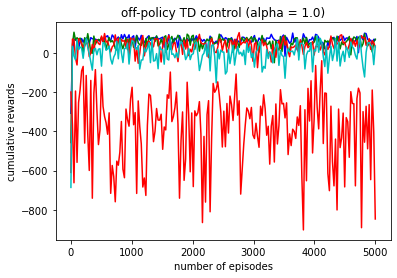

In [42]:
list_of_epsilon = [0.05, 0.1, 0.3, 0.5, 1.0]
graph_colors = ['-b','-g','-r','-c', '-r']

learning_rate = 1.0


for each in range(len(list_of_epsilon)):
    TD_num_episode = 5000
    total_reward = [0] * TD_num_episode
    for i in range(10):
        [Q, policy, cumulative_reward] = rl.OffPolicyTD(nEpisodes=TD_num_episode, epsilon=list_of_epsilon[each], alpha=learning_rate)
        print(Q)
        for i in range(len(cumulative_reward)):
            total_reward[i] += cumulative_reward[i]

    for i in range(len(total_reward)):
        total_reward[i] = total_reward[i]/10

    y = np.array(total_reward)
    x = np.array(list(range(1, TD_num_episode+1)))

    xnew = np.linspace(x.min(), x.max(), 200) 

    #define spline with degree k=7
    spl = make_interp_spline(x, y, k=7)
    y_smooth = spl(xnew)

    #create smooth line chart 
    plt.plot(xnew, y_smooth, graph_colors[each])

plt.xlabel("number of episodes")
plt.ylabel("cumulative rewards")
plt.title("off-policy TD control (alpha = {})".format(learning_rate))
